Loading database at ../datasets/ant_world/routes/ant1_route1...
Using cached result from '.navbench_cache/ipython_get_ann_e61ada7de30c22673d9f728163f900ad229052583056004a4565737fe95f81b3.pkl'
get_ann() took 79.9806 s to run (without caching)
Using cached result from '.navbench_cache/ipython_get_heads_infomax_23150b2a1db991a5005b4d9974d10c2c93ea5f9e4a6c1630d9164225bcdc718f.pkl'
get_heads_infomax() took 17.5674 s to run (without caching)
Using cached result from '.navbench_cache/ipython_get_heads_ridf_8b91e798a40a2d19d8ad9aa811fae190f8053171812df264423c32f58b200960.pkl'
get_heads_ridf() took 7.62606 s to run (without caching)


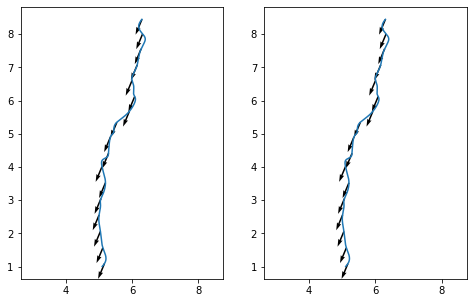

In [4]:
import sys
sys.path.append('..')

import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pathos.multiprocessing as mp

import navbench as nb
import navbench.improc as ip
from navbench.infomax import InfoMax

IM_SIZE = (90, 25)
PREPROC = ip.resize(*IM_SIZE)

db = nb.Database('../datasets/ant_world/routes/ant1_route1')
images = db.read_images(preprocess=PREPROC, to_float=False)

def get_heading_offset(db):
    dists = db.get_cumulative_distances()
    i = 0
    while dists[i] < 0.25:
        i += 1

    offset = db.position[i, :] - db.position[0, :]
    return math.atan2(offset[1], offset[0])

def ridf_to_radians(diffs):
    bestcols = np.argmin(diffs, axis=-1)
    ths = 2 * math.pi * bestcols / diffs.shape[-1]
    return ths

@nb.cache_result
def get_ann(images, im_size, lrate, seed):
    assert not seed is None

    ann = InfoMax(im_size[0] * im_size[1], learning_rate=lrate, seed=seed)
    for im in images:
        ann.train(im)
    return ann

@nb.cache_result
def get_heads_infomax(ann, test_images):
    head_offset = get_heading_offset(db)
    pool = mp.Pool()
    return pool.map(lambda im: head_offset + ridf_to_radians(ann.ridf(im)), test_images)

def get_best_ridf(diffs):
    best_over_rot = np.min(diffs, axis=1)
    best_row = np.argmin(best_over_rot)
    return diffs[best_row, :]

@nb.cache_result
def get_heads_ridf(snapshots, test_images):
    head_offset = get_heading_offset(db)
    heads = [head_offset + ridf_to_radians(get_best_ridf(nb.ridf(snapshots, im))) for im in test_images]
    return heads

ann = get_ann(images, IM_SIZE, InfoMax.DEFAULT_LEARNING_RATE, 42)

test_entries = range(0, len(db), 50)
x = [db.x[i] for i in test_entries]
y = [db.y[i] for i in test_entries]
heads = get_heads_infomax(ann, [images[entry] for entry in test_entries])
u = [math.cos(head) for head in heads]
v = [math.sin(head) for head in heads]

_, ax = plt.subplots(1, 2, figsize=(8, 5))

ax[0].plot(db.x, db.y)
ax[0].quiver(x, y, u, v, angles='xy', scale_units='xy', scale=2)
ax[0].axis('equal')

heads = get_heads_ridf(images, [images[entry] for entry in test_entries])
u = [math.cos(head) for head in heads]
v = [math.sin(head) for head in heads]

ax[1].plot(db.x, db.y)
ax[1].quiver(x, y, u, v, angles='xy', scale_units='xy', scale=2)
ax[1].axis('equal');